In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import sys

In [2]:
print('Python Version: ' + sys.version)
print('Numpy Version: ' + np.__version__)
print('Pandas Version: ' + pd.__version__)
print('Seaborn Version: ' + sn.__version__)

Python Version: 3.7.5 (default, Oct 25 2019, 10:52:18) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy Version: 1.18.1
Pandas Version: 1.0.3
Seaborn Version: 0.10.1


The following class "NeuralNetwork" was taken from the book <i>"Make your own Neural Network"</i>, author: <i>Tariq Rashid</i>. The book decscribes in great detail how to create a neural network step by step. The methods of the class only use functions from Numpy. The method "train" contains in a few lines of code everything that's needed to train a neural network. It produces good results, which will be shown later on by applying the neural network to the MNIST-dataset (more information here: https://en.wikipedia.org/wiki/MNIST_database (110 MB will be downloaded!)).

In [3]:
import scipy.special


class NeuralNetwork:
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes

        self.weights_ih = np.random.normal(0.0, pow(self.hnodes, -0.5),
                                           (self.hnodes, self.inodes))
        self.weights_ho = np.random.normal(0.0, pow(self.onodes, -0.5),
                                           (self.onodes, self.hnodes))

        self.lr_rate = learningrate

        self.activation_function = lambda x: scipy.special.expit(x)   # The expit function, also known as the logistic sigmoid function, is defined as expit(x) = 1/(1+exp(-x)). (See SciPy.org)

    def train(self, inputs_list, targets_list):
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T

        ##### Forward pass: Input Layer to Hidden Layer
        hidden_inputs = np.dot(self.weights_ih, inputs)  # Matrix .dot Vector
        hidden_outputs = self.activation_function(hidden_inputs)

        ##### Forward pass: Hidden Layer to Output Layer
        final_inputs = np.dot(self.weights_ho, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)

        ##### Calculate the error (target - actual)
        output_errors = targets - final_outputs                     # errors of weights between hidden and output layer
        hidden_errors = np.dot(self.weights_ho.T, output_errors)    # errors of weights between input and hidden layer

        ##### Update of the weights (Backpropagation, includes Chain Rule applied to sigmoid activation function)
        # 1st: Update of weights between hidden layer and output layer
        self.weights_ho += self.lr_rate * np.dot((output_errors * final_outputs * (1.0 - final_outputs)),
                                                 np.transpose(hidden_outputs))
        # 2nd: Update of weights between input layer and hidden layer
        self.weights_ih += self.lr_rate * np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)),
                                                 np.transpose(inputs))

    def query(self, inputs_list):
        inputs = np.array(inputs_list, ndmin=2).T

        hidden_inputs = np.dot(self.weights_ih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)

        final_inputs = np.dot(self.weights_ho, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)

        return final_outputs

In [4]:
# Set the parameters for the Neural Network
input_nodes = 784      # The images that the neural network is trained on are of size 28x28 = 784 
hidden_nodes = 100
output_nodes = 10      # The images contain the numbers 0-9
learning_rate = 0.2

In [5]:
# Instantiate the Neural Network
nn = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

In [6]:
# Load the training data (110 MB !!!)
url = 'http://www.pjreddie.com/media/files/mnist_train.csv'
df_training_data = pd.read_csv(url, sep=',', header=None)

In [7]:
df_training_data.head(2)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The numbers in column 0 refer to the label. The numbers in column 1 to 784 refer to the grey values of the image.

In [8]:
%%time

# Preprocess the data (for example standardize the grey values to be lying between 0.01 and 1.0)
def preprocess(df_data):
    targets_all = np.zeros((len(df_data), output_nodes)) + 0.01
    targets_all[np.arange(len(targets_all)), df_data.iloc[:, 0].values] = 0.99
    inputs_all = (df_data.iloc[:, 1:].values / 255.0 * 0.99) + 0.01
    return targets_all, inputs_all

training_targets_all, training_inputs_all = preprocess(df_training_data)

CPU times: user 288 ms, sys: 117 ms, total: 406 ms
Wall time: 425 ms


In [9]:
%%time

# Training with all available data samples for 1 epoch (multiple epochs do not improve the test result)
for epoch in range(1):
    print('TRAINING with ' + str(len(training_targets_all)) + ' data samples...   Epoch: ' + str(epoch + 1) + '\n')
    for inputs, targets in zip(training_inputs_all, training_targets_all):
        nn.train(inputs, targets)

TRAINING with 60000 data samples...   Epoch: 1

CPU times: user 31.6 s, sys: 873 ms, total: 32.4 s
Wall time: 21.6 s


In [10]:
# Load the test data ()
url = 'http://www.pjreddie.com/media/files/mnist_test.csv'
df_testing_data = pd.read_csv(url, sep=',', header=None)

In [11]:
%%time

# Testing
output_correct = df_testing_data.iloc[:, 0].values
testing_targets_all, testing_inputs_all = preprocess(df_testing_data)
print('TESTING with ' + str(len(testing_targets_all)) + ' data samples...\n')
output_tmp = list(map(nn.query, testing_inputs_all))
output_nn = np.array(list(map(np.argmax, output_tmp)))

TESTING with 10000 data samples...

CPU times: user 711 ms, sys: 32.6 ms, total: 744 ms
Wall time: 463 ms


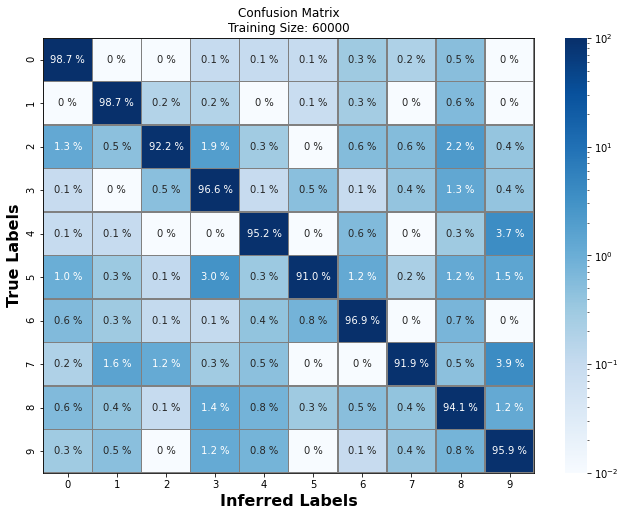

In [12]:
%matplotlib inline

from matplotlib.colors import LogNorm
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(output_correct, output_nn, normalize='true') * 100
moin = np.where(conf_matrix > 0.0, conf_matrix, 0.01)
ax = sn.heatmap(moin, annot=True, fmt='.1f', cmap=plt.cm.Blues,
                vmax=100, linewidths=0.5, linecolor='grey', norm=LogNorm())
ax.set_title('Confusion Matrix\n' + f'Training Size: {str(len(training_targets_all))}')
ax.set_xlabel('Inferred Labels', fontsize=16, fontweight='bold')
ax.set_ylabel('True Labels', fontsize=16, fontweight='bold')

# Make the figure a bit nicer
for _, spine in ax.spines.items():
    spine.set_visible(True)
for text in ax.texts:
    if text.get_text() == '0.0':
        text.set_text('0')
    text.set_text(text.get_text() + " %")
plt.gcf().set_size_inches(11,8)

In [13]:
from sklearn.metrics import classification_report

print(classification_report(output_correct, output_nn, digits=3))

              precision    recall  f1-score   support

           0      0.959     0.987     0.973       980
           1      0.968     0.987     0.977      1135
           2      0.977     0.922     0.949      1032
           3      0.924     0.966     0.945      1010
           4      0.966     0.952     0.959       982
           5      0.978     0.910     0.943       892
           6      0.963     0.969     0.966       958
           7      0.977     0.919     0.947      1028
           8      0.918     0.941     0.930       974
           9      0.899     0.959     0.928      1009

    accuracy                          0.952     10000
   macro avg      0.953     0.951     0.952     10000
weighted avg      0.953     0.952     0.952     10000

